In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn import metrics
import skforecast
from sklearn.ensemble import RandomForestRegressor 
import xgboost as xgb
from sklearn.metrics import root_mean_squared_error,mean_squared_error, make_scorer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from skforecast.exceptions import LongTrainingWarning
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import Ridge
import warnings

In [172]:
df = pd.read_csv("../data/homogeneized/Madrid/datos_Madrid_homogenizados.csv")

In [173]:
df.dtypes

date               object
precipitation     float64
wind_speed_10m    float64
temperature       float64
hr                float64
dtype: object

In [174]:
df["date"].head(1)

0    2020-01-01 00:00:00
Name: date, dtype: object

In [175]:
# Creo 4 columnas nuevas para luego hacer la funcion seno coseno
df["date"] = pd.to_datetime(df["date"])
df['año'] = df['date'].dt.year
df['mes'] = df['date'].dt.month
df['dia'] = df['date'].dt.day
df['hora'] = df['date'].dt.hour

### AÑADIENDO VARIABLES EXÓGENAS

In [176]:
# Creo una nueva columna que dependiendo del mes en el que se encuentre corresponderá a una estación u otra
for i, mes in enumerate(df["mes"]):
    if mes in [12, 1, 2]:
        df.loc[i, "estacion"] = "Invierno"
    elif mes in [3, 4, 5]:
        df.loc[i, "estacion"] = "Primavera"
    elif mes in [6, 7, 8]:
        df.loc[i, "estacion"] = "Verano"
    else:
        df.loc[i, "estacion"] = "Otoño"
        

In [177]:
# Get dummies de la columna estación para convertirlo a numérico
df_encoded = pd.get_dummies(df["estacion"], dtype = int, drop_first=True)

In [178]:
# Meto las columnas en el dataframe original
df[["Otoño","Primavera","Verano"]] = df_encoded

In [179]:
# Funcion seno coseno para hacer las variables mes y dia cíclicas
df["MONTH_SIN"] = np.sin(2 * np.pi * df["mes"] / 12)
df["MONTH_COS"] = np.cos(2 * np.pi * df["mes"] / 12)
df["DAY_SIN"] = np.sin(2 * np.pi * df["dia"] / 365)
df["DAY_COS"] = np.cos(2 * np.pi * df["dia"] / 365)
df["HOUR_SIN"] = np.sin(2 * np.pi * df["dia"] / 24)
df["HOUR_COS"] = np.cos(2 * np.pi * df["dia"] / 24)

## PREDICCIÓN HORARIA
- Predicción 1 hora: 
    - Temperatura
    - Humedad relativa
- Predicción 24 horas: 
    - Temperatura
    - Humedad relativa


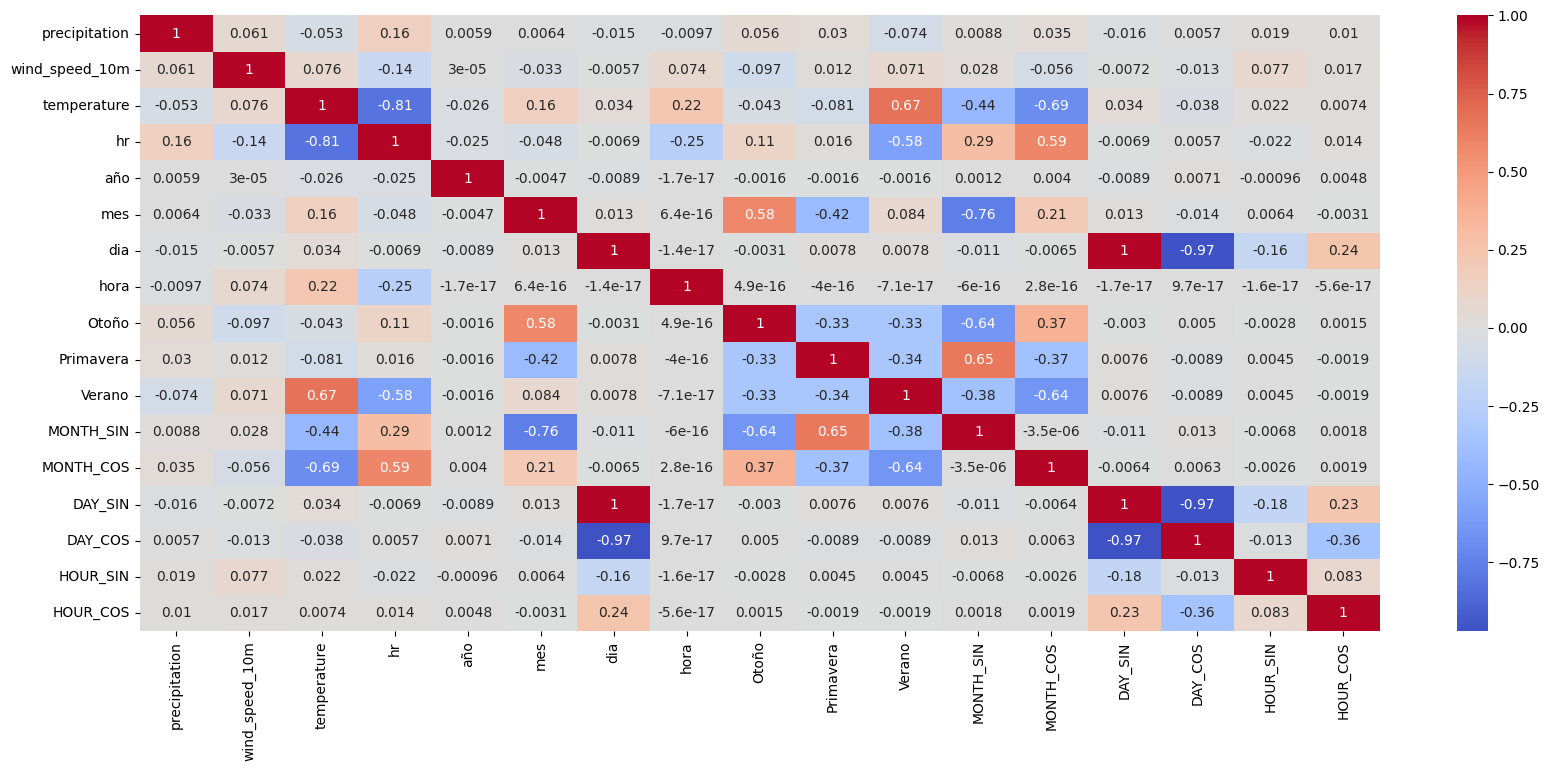

In [180]:
# Se puede observar que para predecir la temperatura media el mes tiene importancia
plt.figure(figsize=(20, 8))
correlation_matrix = df.corr(numeric_only=True)

# Crear un mapa de calor para visualizar la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0)
plt.show()

In [181]:
# Calcula la media de la temperatura por grupo ("dia" y "hora") y asigna el resultado a una nueva columna
df["temp_med_dia_mes"] = df.groupby(["dia", "hora"])["temperature"].transform("mean")

# Calcula la media de humedad por grupo ("dia" y "hora") y asigna el resultado a una nueva columna
df["hr_med_dia_mes"] = df.groupby(["dia", "hora"])["hr"].transform("mean")

In [182]:
df.columns

Index(['date', 'precipitation', 'wind_speed_10m', 'temperature', 'hr', 'año',
       'mes', 'dia', 'hora', 'estacion', 'Otoño', 'Primavera', 'Verano',
       'MONTH_SIN', 'MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS',
       'temp_med_dia_mes', 'hr_med_dia_mes'],
      dtype='object')

In [183]:
# Creo los distintos dataframes que se usarán para las predicciones de la temperatura y humedad relativa
df_temp = df.drop(columns=['date', 'precipitation', 'wind_speed_10m','hr','hr_med_dia_mes', 'año','mes','dia','hora','estacion'])
df_hr_med = df.drop(columns=['date','precipitation', 'wind_speed_10m','temperature','temp_med_dia_mes','año','mes','dia','hora','estacion'])

In [185]:
# cojo la información de las columnas exógenas de los 24 dias de febrero que voy a tener que predecir
# Es la misma información que tendrían los días que voy a predecir porque es la misma estación, mismas fechas y misma media de temperatura
fechas_a_predecir = df.loc[(df["date"] >= '2022-01-01') & (df["date"] <= '2022-01-02')]

temp_media_dia_mes = fechas_a_predecir["temp_med_dia_mes"].to_list()
hr_med_dia_mes = fechas_a_predecir["hr_med_dia_mes"].to_list()
otonio = fechas_a_predecir["Otoño"].to_list()
primavera = fechas_a_predecir["Primavera"].to_list()
verano = fechas_a_predecir["Verano"].to_list()
lista_mes_seno = fechas_a_predecir["MONTH_SIN"].to_list()
lista_mes_coseno = fechas_a_predecir["MONTH_COS"].to_list()
lista_dia_seno = fechas_a_predecir["DAY_SIN"].to_list()
lista_dia_coseno = fechas_a_predecir["DAY_COS"].to_list()
lista_hora_seno = fechas_a_predecir["HOUR_SIN"].to_list()
lista_hora_coseno = fechas_a_predecir["HOUR_COS"].to_list()


dic = {"temp_med_dia_mes":temp_media_dia_mes
       ,"hr_med_dia_mes":hr_med_dia_mes
       ,"Otoño":otonio
       ,"Primavera":primavera
       ,"Verano":verano
       ,"MONTH_SIN":lista_mes_seno
       ,"MONTH_COS":lista_mes_coseno
       ,"DAY_SIN":lista_dia_seno
       ,"DAY_COS":lista_dia_coseno
       ,"HOUR_SIN":lista_hora_seno
       ,"HOUR_COS":lista_hora_coseno}


df_predicciones = pd.DataFrame(dic)

# Cojo el ultimo indice del dataframe original y reescribo el nuevo para que parezca que es la continuación del anterior
# Lo hago porque al aplicar el modelo recursive, al coger steps tienen que tener un indice seguido.
inicio = df.shape[0]
df_predicciones.index= [i for i in range(inicio, inicio +24)]

# df para la predicción del dia siguiente
df_predicciones_1_dia = df_predicciones.head(1)


,temp_med_dia_mes,hr_med_dia_mes,Otoño,Primavera,Verano,MONTH_SIN,MONTH_COS,DAY_SIN,DAY_COS,HOUR_SIN,HOUR_COS
17568,12.9625,71.900960,0,0,0,0.5,0.866025,0.017213,0.999852,0.258819,0.965926
17569,12.3085,73.786220,0,0,0,0.5,0.866025,0.017213,0.999852,0.258819,0.965926
17570,11.7285,75.316102,0,0,0,0.5,0.866025,0.017213,0.999852,0.258819,0.965926
17571,11.1965,76.529001,0,0,0,0.5,0.866025,0.017213,0.999852,0.258819,0.965926
17572,10.7285,77.597163,0,0,0,0.5,0.866025,0.017213,0.999852,0.258819,0.965926
17573,10.4185,77.994682,0,0,0,0.5,0.866025,0.017213,0.999852,0.258819,0.965926
17574,10.4345,77.549603,0,0,0,0.5,0.866025,0.017213,0.999852,0.258819,0.965926
17575,11.1505,75.497638,0,0,0,0.5,0.866025,0.017213,0.999852,0.258819,0.965926
17576,12.4025,70.490748,0,0,0,0.5,0.866025,0.017213,0.999852,0.258819,0.965926
17577,14.1145,64.627517,0,0,0,0.5,0.866025,0.017213,0.999852,0.258819,0.965926


## MODELOS
- **REGRESIÓN LINEAL RIDGE:** 
    - Es una variante de la regresión lineal que se utiliza para manejar problemas de multicolinealidad (cuando las variables predictoras están altamente   correlacionadas entre sí). 
    - A diferencia de la regresión lineal tradicional, Ridge introduce un término de regularización que penaliza los coeficientes del modelo para evitar que tomen valores extremos, es decir, reduce el overfitting.
- **SKFORECAST RECURSIVE:**
    - Skforecast es una librería de Python diseñada para facilitar la creación de modelos de pronóstico (forecasting) utilizando técnicas de aprendizaje automático. 
    - El enfoque Recursive es una estrategia para hacer predicciones multi-paso (multi-step forecasting) en series temporales.
    - En lugar de entrenar un modelo separado para cada paso de predicción, se entrena un único modelo que se utiliza de manera recursiva.
    - En cada paso, la predicción anterior se usa como entrada para predecir el siguiente valor.
- **XGBOOST REGRESSOR:**
    - Combina múltiples modelos débiles de árboles de regresión para crear un modelo más potente.
    - Cada árbol intenta corregir los errores del anterior.
    - Al igual que el modelo Ridge, incluye un término de regularización para reducir el overfitting.
- **RANDOM FOREST REGRESSOR:**
    - Combina múltiples árboles de regresión para crear un modelo más robusto.

## TEMPERATURA

In [186]:
# Datos de entrenamiento y test
train_size = int(len(df_temp)*0.9)

data_train = df_temp.iloc[:train_size]
data_test = df_temp.iloc[train_size:]


### RANDOM FOREST REGRESSOR (Predicción 1 hora)

In [187]:

# Hiperparámetros para que encuentre el mejor
param_grid = {
    'n_estimators': [8, 10, 18, 20, 50, 80, 100],
    'criterion': ['squared_error'],
    'min_samples_split': [2, 3, 4, 5],
    'max_depth': [2, 3, 4]
}

# Modelo
regr = RandomForestRegressor(random_state=2517)

# Métrica RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

# Este tipo de división no me mezcla las fechas, es decir, no hay data leakage
tscv = TimeSeriesSplit(n_splits=5)  # 5 divisiones temporales

grid_search = GridSearchCV(
    estimator=regr,
    param_grid=param_grid,
    scoring=rmse_scorer,  
    cv=tscv, 
    n_jobs=-1 
)

grid_search.fit(data_train[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']], data_train[['temperature']])

# Mejores hiperparámetros y RMSE
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor RMSE:", np.sqrt(-grid_search.best_score_))  # Convertir a RMSE

c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mejores hiperparámetros: {'criterion': 'squared_error', 'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 18}
Mejor RMSE: 2.9394399013575185


In [188]:
# Create and train forecaster
# ==============================================================================
# Entrenarlo con los mejores parámetros obtenidos
forecaster = ForecasterRecursive(
                 regressor = RandomForestRegressor(criterion= 'squared_error', max_depth= 4, min_samples_split= 2, n_estimators= 18,random_state=2517),
                 lags      = 10
             )
forecaster.fit(y=data_train['temperature'], exog = data_train[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']])

# Hago una prediccion para todos los valores de test
predictions = forecaster.predict(steps=1, exog = data_test[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']])

# Para saber cuantos steps coger, cojo 1 step
y_buena = df_temp[15811:15812]
y_buena = y_buena["temperature"]


rmse =  root_mean_squared_error(y_buena, predictions)
rmse

0.29760203977265576

### Resultados predicción 1 hora

In [189]:
# Predicciones para 1 hora
forecaster.fit(exog = df_temp[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']],y= df_temp["temperature"])
p = forecaster.predict(steps = 1, exog = df_predicciones_1_dia[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']])
p

c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1292: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


17568    5.129396
Name: pred, dtype: float64

### FORECASTER RECURSIVE (Predicción 24 horas)

In [190]:
# Create and train forecaster
# ==============================================================================
# Entrenarlo con los mejores parámetros obtenidos
forecaster = ForecasterRecursive(
                 regressor = Ridge( random_state=2517),
                 lags      = 10
             )
forecaster.fit(y=data_train['temperature'], exog = data_train[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']])

# Hago una prediccion para todos los valores de test
predictions = forecaster.predict(steps=24, exog = data_test[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']])

# Para saber cuantos steps coger, cojo 24 step
y_buena = df_temp[15811:15835]
y_buena = y_buena["temperature"]


rmse =  root_mean_squared_error(y_buena, predictions)
rmse

2.7439443393873253

### Resultados predicción 24 horas

In [191]:
forecaster.fit(y=df_temp['temperature'], exog = df_temp[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']])

# Hago una prediccion para todos los valores de test
predictions = forecaster.predict(steps=24, exog = df_predicciones[['temp_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']])

predictions

c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1292: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


17568    4.194700
17569    3.760650
17570    3.602924
17571    3.638829
17572    3.922904
17573    4.589656
17574    5.276600
17575    5.729117
17576    6.219057
17577    6.645268
17578    6.971233
17579    7.197852
17580    7.325877
17581    7.347752
17582    7.256985
17583    7.096963
17584    6.910128
17585    6.694086
17586    6.463309
17587    6.230892
17588    6.002901
17589    5.788446
17590    5.599466
17591    5.439899
Name: pred, dtype: float64

## HUMEDAD RELATIVA
### XGBOOST (Predicción 1 hora)

In [192]:
# Datos de entrenamiento y test
train_size = int(len(df_hr_med)*0.9)

data_train = df_hr_med.iloc[:train_size]
data_test = df_hr_med.iloc[train_size:]


In [193]:

# Hiperparámetros para que encuentre el mejor
param_grid = {
    'n_estimators': [8, 10, 18, 20, 50, 80, 100],
    'colsample_bytree':[0.8],
    'learning_rate':[0.1],
    'subsample':[0.8],
    'max_depth': [2, 3, 4]
}

# Modelo
regr = xgb.XGBRegressor(random_state=2517)

# Métrica RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

# Este tipo de división no me mezcla las fechas, es decir, no hay data leakage
tscv = TimeSeriesSplit(n_splits=5)  # 5 divisiones temporales

grid_search = GridSearchCV(
    estimator=regr,
    param_grid=param_grid,
    scoring=rmse_scorer,  
    cv=tscv, 
    n_jobs=-1 
)

grid_search.fit(data_train[['hr_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']], data_train[['hr']])

# Mejores hiperparámetros y RMSE
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor RMSE:", np.sqrt(-grid_search.best_score_))  # Convertir a RMSE

Mejores hiperparámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 50, 'subsample': 0.8}
Mejor RMSE: 4.513172535898414


In [194]:
# Create and train forecaster
# ==============================================================================
# Entrenarlo con los mejores parámetros obtenidos
forecaster = ForecasterRecursive(
                 regressor = xgb.XGBRegressor( max_depth= 2, colsample_bytree=0.8,learning_rate=0.1,subsample=0.8, n_estimators= 50,random_state=2517),
                 lags      = 10
             )
forecaster.fit(y=data_train['hr'], exog = data_train[['hr_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']])

# Hago una prediccion para todos los valores de test
predictions = forecaster.predict(steps=1, exog = data_test[['hr_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']])

# Para saber cuantos steps coger, cojo 1 step
y_buena = df_hr_med[15811:15812]
y_buena = y_buena["hr"]


rmse =  root_mean_squared_error(y_buena, predictions)
rmse

0.3716349501953147

### Resultados predicción 1 hora

In [195]:
forecaster.fit(y=df_hr_med['hr'], exog = df_hr_med[['hr_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']])

# Hago una prediccion para todos los valores de test
predictions = forecaster.predict(steps=1, exog = df_predicciones_1_dia[['hr_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']])
predictions

c:\Users\dani0\AppData\Local\Programs\Python\Python312\Lib\site-packages\skforecast\utils\utils.py:1292: UserWarning: `exog` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


17568    78.214828
Name: pred, dtype: float64

## RIDGE (Predicción 24 horas)

In [196]:
# Create and train forecaster
# ==============================================================================

regressor = Ridge(random_state=2521)
               
regressor.fit(data_train[['hr_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']],data_train['hr'])

# Hago una prediccion para todos los valores de test
predictions = regressor.predict(data_test[['hr_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']])

# Para saber cuantos steps coger, cojo 1 step
y_buena = df_hr_med[15811:15835]
y_buena = y_buena["hr"]
predictions = predictions[:24]


rmse =  root_mean_squared_error(y_buena, predictions)
rmse

7.54614959019954

### Resultados prediccón 24 horas

In [197]:
regressor.fit(df_hr_med[['hr_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']],df_hr_med['hr'])

# Hago una prediccion para todos los valores de test
predictions = regressor.predict(df_predicciones[['hr_med_dia_mes', 'Otoño', 'Primavera', 'Verano','MONTH_SIN','MONTH_COS', 'DAY_SIN', 'DAY_COS', 'HOUR_SIN', 'HOUR_COS']])
predictions

array([92.47845987, 94.36343567, 95.89308709, 97.10580228, 98.17380335,
       98.57126245, 98.12625115, 96.07459551, 91.0684604 , 85.20611375,
       80.4696224 , 75.67750445, 72.46486771, 69.4635298 , 68.06319354,
       67.52617189, 68.85578204, 71.82065676, 74.94720555, 78.45960362,
       82.47669019, 85.28050825, 86.33202452, 88.41183393])